In [3]:
import os
import json
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [4]:
def load_data(path):
    imgs, lbls = zip(*[ (os.path.join(path, label, image), label)
                for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))
                    for image in os.listdir(os.path.join(path, label))
    ])
    return pd.DataFrame({
        "Image": imgs,
        "Class": lbls
    })

In [5]:
train = load_data("./Dataset/Training")
test = load_data("./Dataset/Testing")

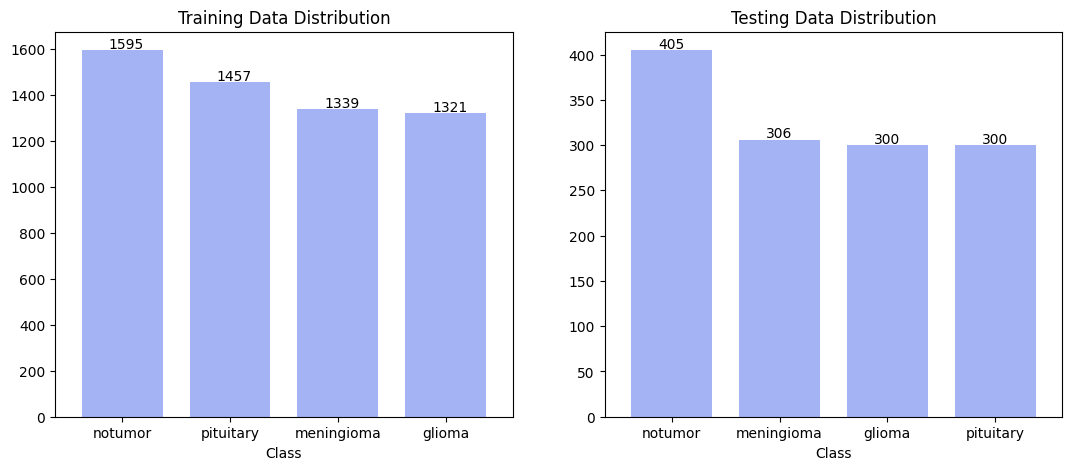

In [14]:
plt.figure(figsize=(13, 5))

for i, df in enumerate([train, test]):
    plt.subplot(1, 2, i+1)
    df["Class"].value_counts().plot.bar(width=0.75, color='#A3B3F3')
    plt.title(f"{'Training' if i==0 else 'Testing'} Data Distribution")
    plt.xticks(rotation=0)
    h = max(df["Class"].value_counts())
    for i, v in enumerate(df['Class'].value_counts()):
        plt.text(i-0.125, v+h/200, str(v))

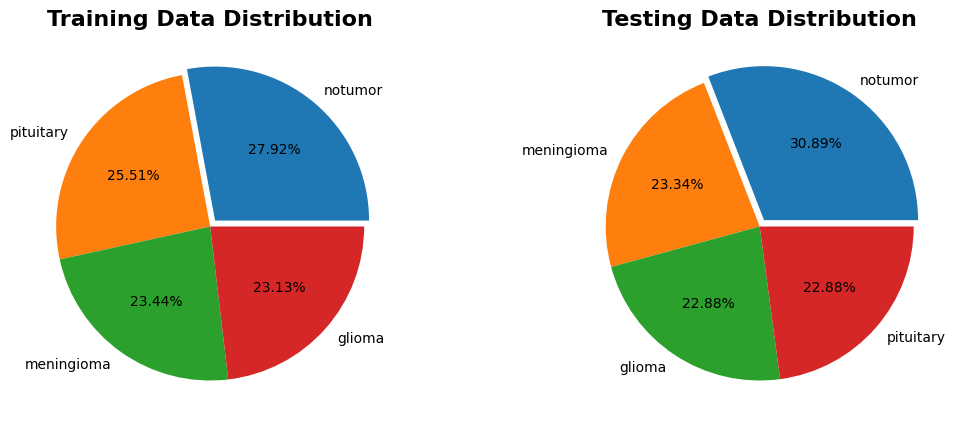

In [15]:
plt.figure(figsize=(13, 5))

for i, df in enumerate([train, test]):
    plt.subplot(1, 2, i+1)
    df["Class"].value_counts().plot.pie(autopct='%.2f%%', explode=(0.05, 0, 0, 0))
    plt.title(f"{'Training' if i==0 else 'Testing'} Data Distribution", fontdict={'weight': 'bold', 'size': 16})
    plt.ylabel(None)

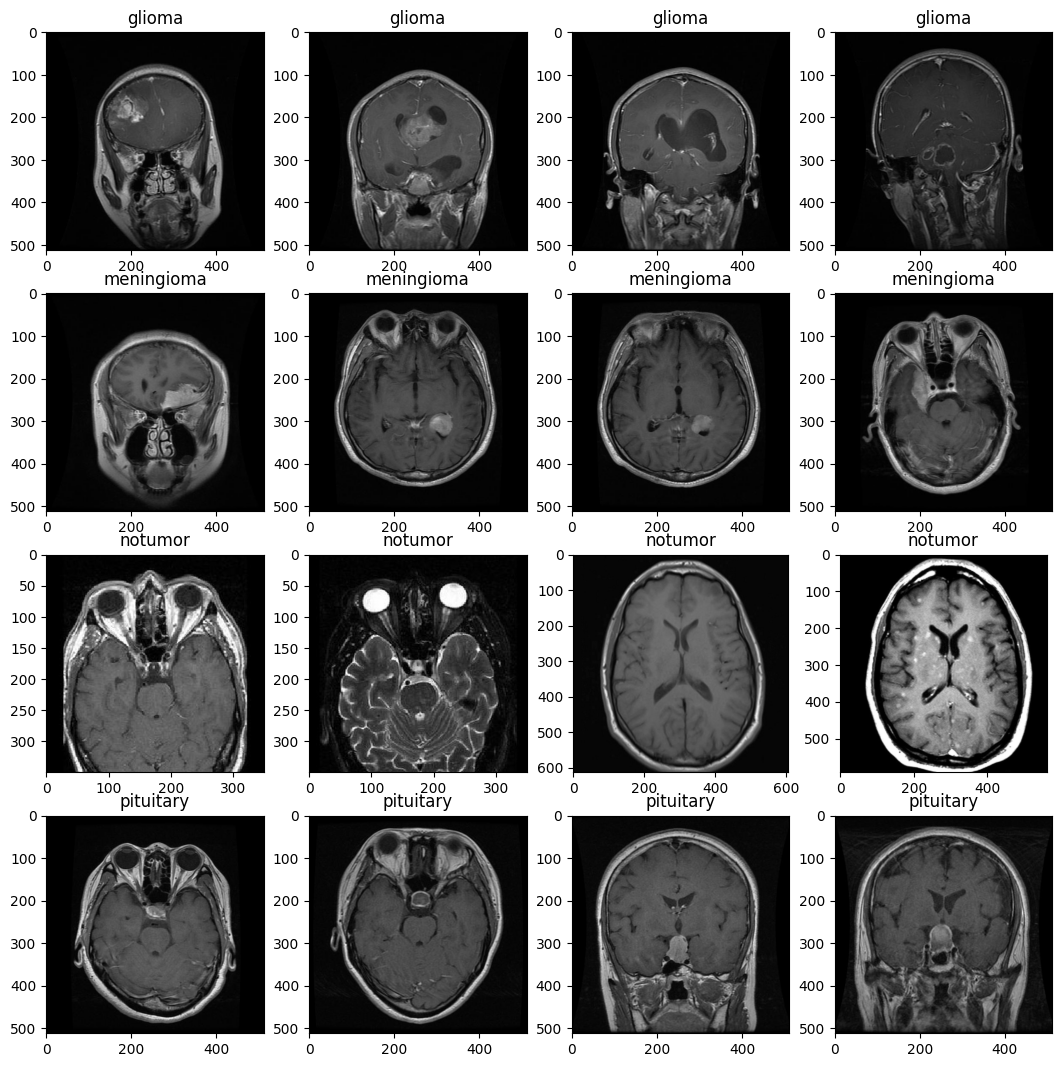

In [16]:
plt.figure(figsize=(13, 13))

for i, lbl in  enumerate(train['Class'].unique()):
    for j, im in enumerate(train[train['Class'] == lbl]['Image'][:4]):
        plt.subplot(4, 4 , i*4+j+1)
        plt.imshow(Image.open(im))
        plt.title(lbl)

In [17]:
test, valid = train_test_split(test, test_size=0.5, stratify=test['Class'])

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5820)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

Virtual devices cannot be modified after being initialized


In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', brightness_range=(0.8, 1.2)
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Image',
    y_col='Class',
    target_size=(299,299),
    batch_size=16,
    class_mode='categorical'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=valid,
    x_col='Image',
    y_col='Class',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Image',
    y_col='Class',
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


In [10]:
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

img_shape =(299, 299, 3)

base_model = Xception(include_top=False,  weights="imagenet", input_shape= img_shape, pooling='max')

base_model.layers[-1].activation = None

x = base_model.output
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()]
)

In [4]:
from keras.utils import plot_model
plot_model(model)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath = "Models/Xception/wave_2/model_epoch_{epoch:02}.keras",
    save_weights_only = False,
    save_best_only = False,
    monitor = 'val_loss',
    mode = 'min',
    verbose = 0
)

In [12]:
import tensorflow.keras.backend as K
K.clear_session()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20, batch_size=16,
    callbacks = [checkpoint]
)

# Summmarizing

In [ ]:
hist = history.history

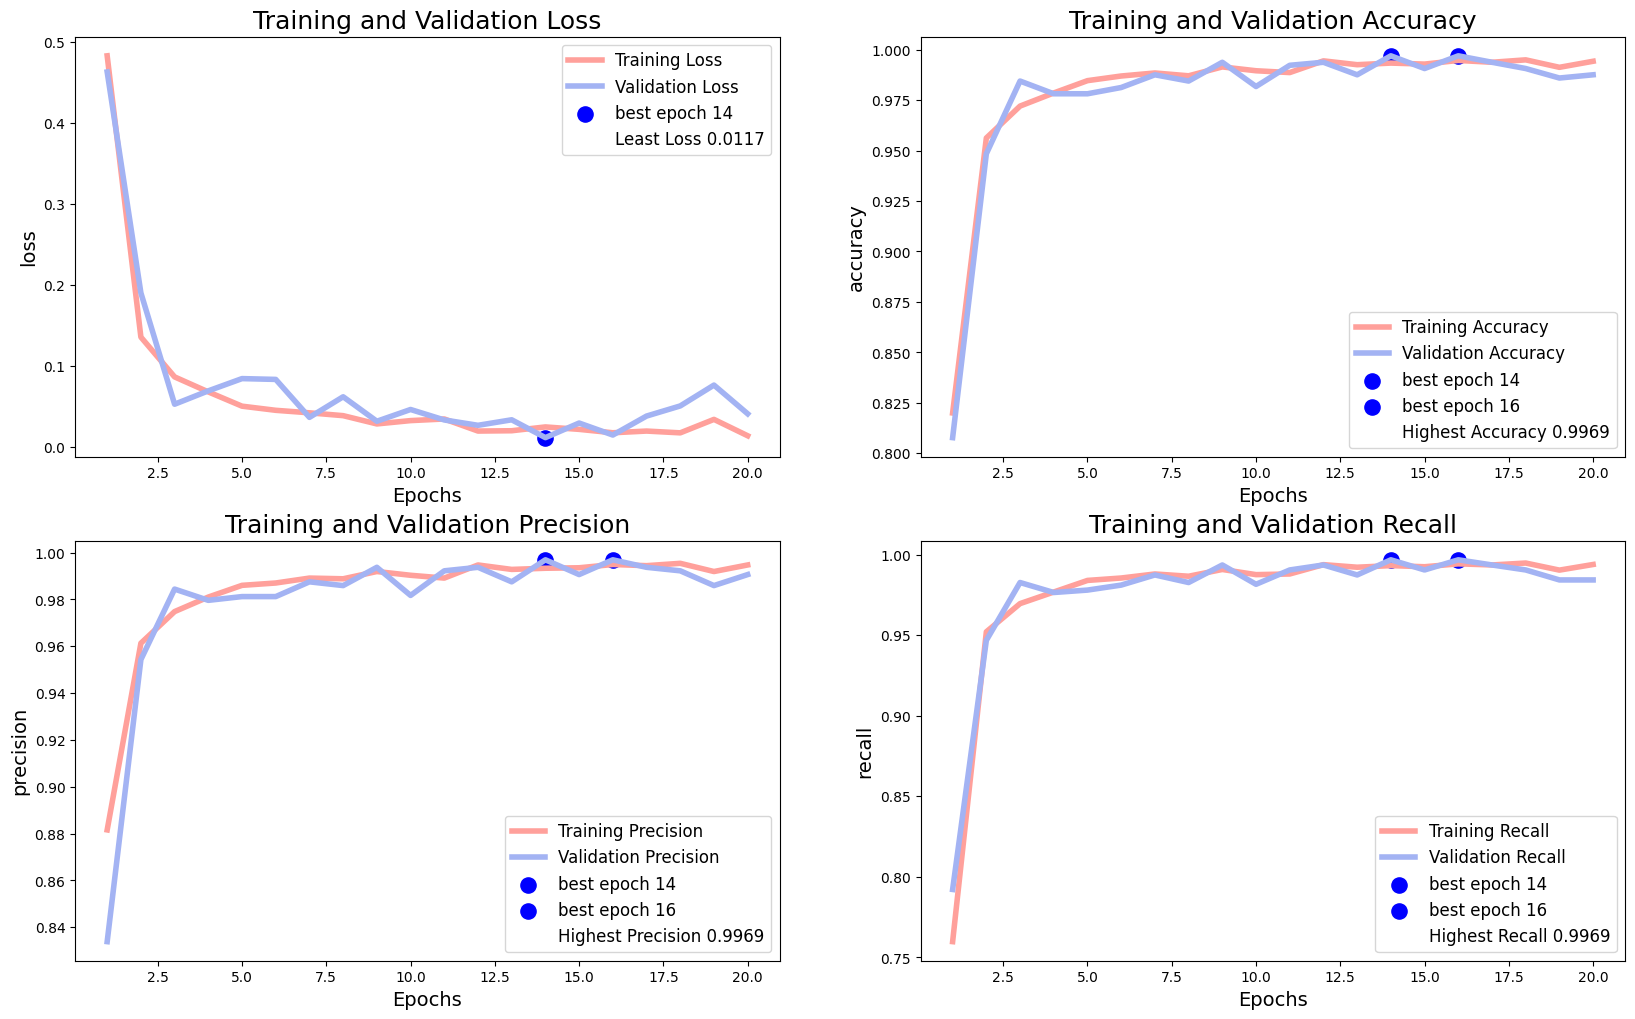

In [34]:
TRAIN_CLR = '#FFA09B'
VAL_CLR  = '#A3B3F3'
BEST_CLR = 'b'

plt.style.reload_library()
epochs = [i for i in range(1, len(hist['loss'])+1)]
plt.figure(figsize=(20, 12))
for i, m in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    train_values = hist[m]
    val_values = hist[f'val_{m}']
    if m == 'loss':
        best_value = np.min(val_values)
    else:
        best_value = np.max(val_values)
    best_epochs = [j for j, v in enumerate(val_values) if v == best_value]

    plt.subplot(2, 2, i+1)
    plt.plot(epochs, train_values, color=TRAIN_CLR, label = f"Training {m.capitalize()}", linewidth=4)
    plt.plot(epochs, val_values, color=VAL_CLR, label = f"Validation {m.capitalize()}", linewidth=4)
    for e in best_epochs:
        plt.scatter(e+1, best_value, color=BEST_CLR, s=120, label=f'best epoch {e+1}')
    plt.scatter(best_epochs[0]+1, best_value, color=BEST_CLR, s=0, label=f"{'Least' if m == 'loss' else 'Highest'} {m.capitalize()} {best_value}")
    plt.title(f"Training and Validation {m.capitalize()}", fontdict={'size':18})
    plt.xlabel('Epochs', fontdict={'size':14})
    plt.ylabel(m, fontdict={'size':14})
    plt.legend(fontsize=12)

# Testing

In [59]:
directory = r'./Models/Xception/'

scores = {'loss': [], 'accuracy': [], 'precision': [], 'recall':[]}
for path in os.listdir(directory):
    if path.endswith('.keras'):
        mod = load_model(os.path.join(directory, path))
        score = mod.evaluate(test_generator, verbose=0)
        for i, key in enumerate(scores.keys()):
            scores[key].append(score[i])


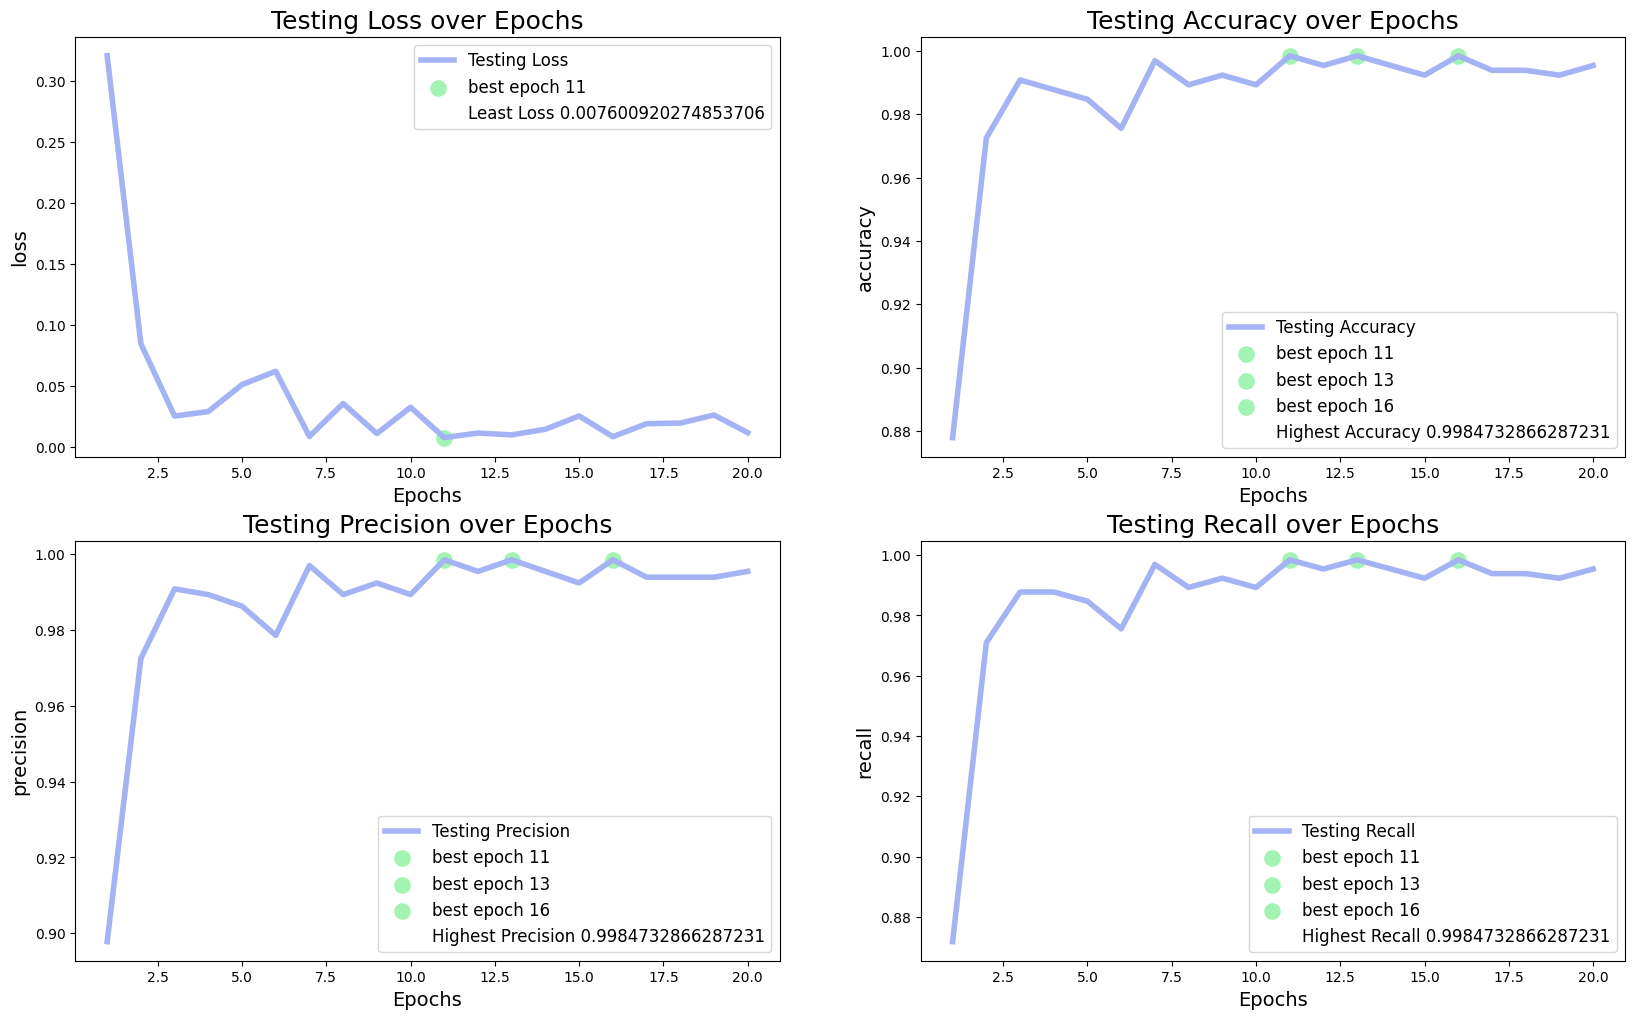

In [60]:
TEST_CLR  = '#A3B3F3'
BEST_CLR = '#A3F3B3'

epochs = [i for i in range(1, len(scores['loss'])+1)]
plt.figure(figsize=(20, 12))
for i, m in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    values = scores[m]
    if m == 'loss':
        best_value = np.min(values)
    else:
        best_value = np.max(values)
    best_epochs = [j for j, v in enumerate(values) if v == best_value]

    plt.subplot(2, 2, i+1)
    plt.plot(epochs, values, color=TEST_CLR, label = f"Testing {m.capitalize()}", linewidth=4)
    for e in best_epochs:
        plt.scatter(e+1, best_value, color=BEST_CLR, s=120, label=f'best epoch {e+1}')
    plt.scatter(best_epochs[0]+1, best_value, color=BEST_CLR, s=0, label=f"{'Least' if m == 'loss' else 'Highest'} {m.capitalize()} {best_value}")
    plt.title(f"Testing {m.capitalize()} over Epochs", fontdict={'size':18})
    plt.xlabel('Epochs', fontdict={'size':14})
    plt.ylabel(m, fontdict={'size':14})
    plt.legend(fontsize=12)

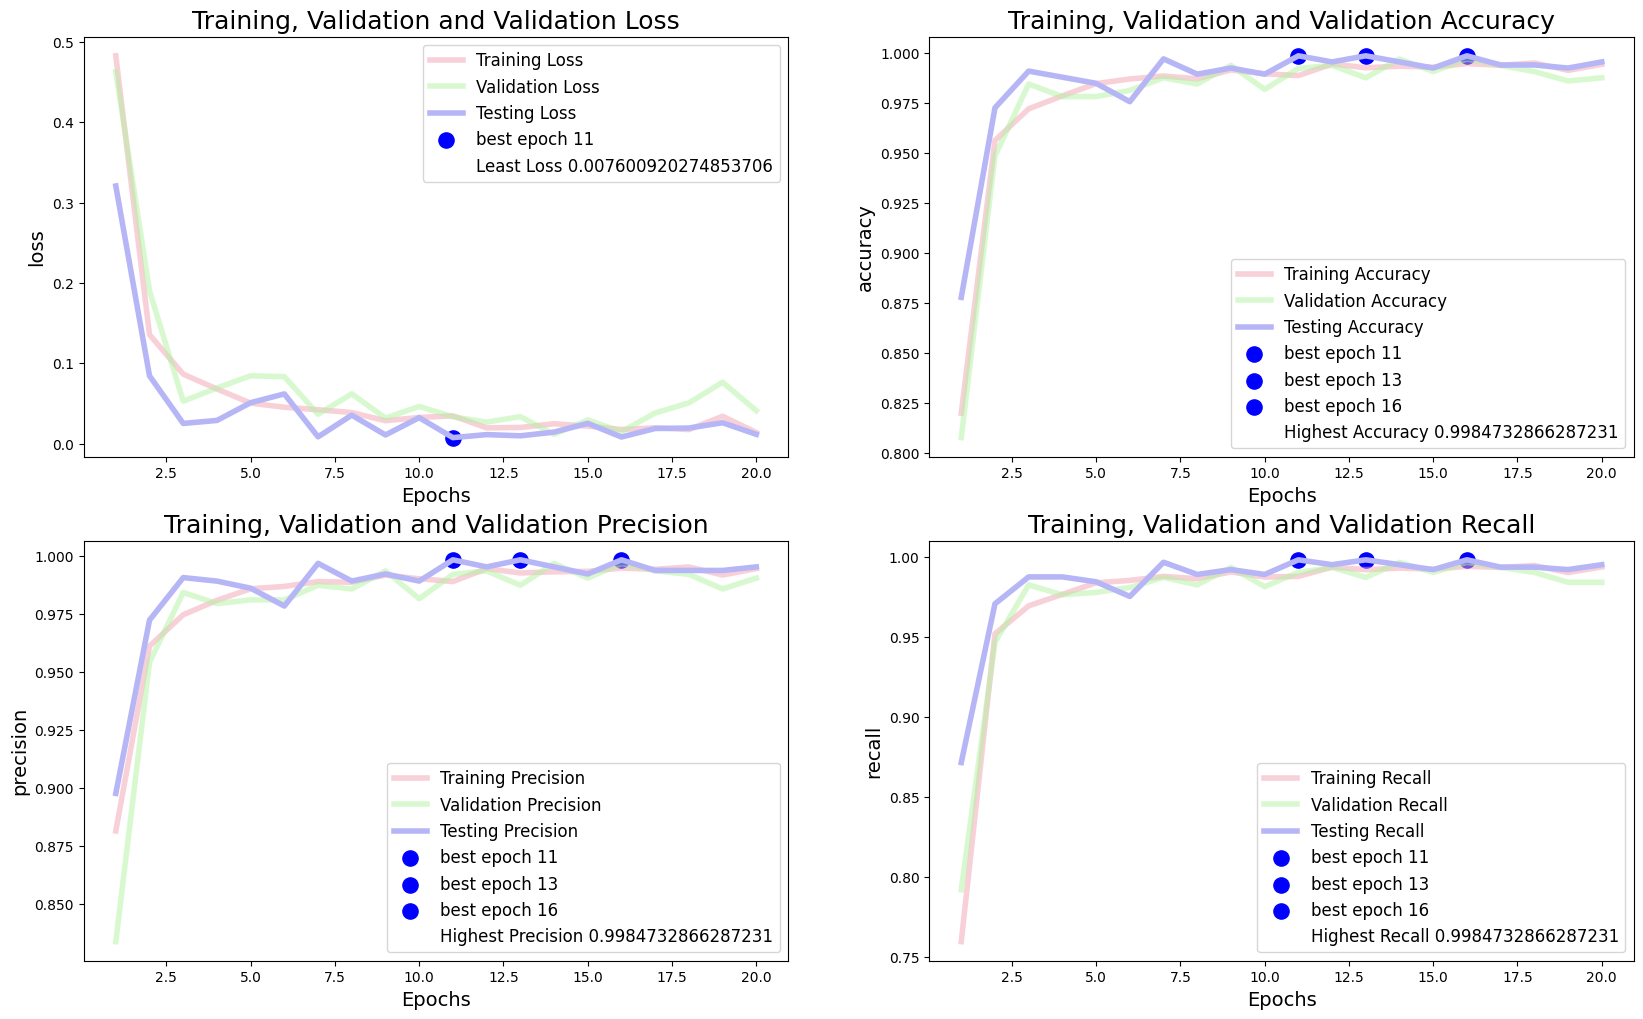

In [62]:
TRAIN_CLR = '#F3A3B3'
VAL_CLR  = '#B3F3A3'
TEST_CLR  = '#B6B6F6'
BEST_CLR = 'b'

plt.style.reload_library()
epochs = [i for i in range(1, len(hist['loss'])+1)]
plt.figure(figsize=(20, 12))
for i, m in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    train_values = hist[m]
    val_values = hist[f'val_{m}']
    test_values = scores[m]
    if m == 'loss':
        best_value = np.min(test_values)
    else:
        best_value = np.max(test_values)
    best_epochs = [j for j, v in enumerate(test_values) if v == best_value]

    plt.subplot(2, 2, i+1)
    plt.plot(epochs, train_values, color=TRAIN_CLR, label = f"Training {m.capitalize()}", linewidth=4, alpha=0.5)
    plt.plot(epochs, val_values, color=VAL_CLR, label = f"Validation {m.capitalize()}", linewidth=4, alpha=0.5)
    plt.plot(epochs, test_values, color=TEST_CLR, label = f"Testing {m.capitalize()}", linewidth=4)
    for e in best_epochs:
        plt.scatter(e+1, best_value, color=BEST_CLR, s=120, label=f'best epoch {e+1}')
    plt.scatter(best_epochs[0]+1, best_value, color=BEST_CLR, s=0, label=f"{'Least' if m == 'loss' else 'Highest'} {m.capitalize()} {best_value}")
    plt.title(f"Training, Validation and Validation {m.capitalize()}", fontdict={'size':18})
    plt.xlabel('Epochs', fontdict={'size':14})
    plt.ylabel(m, fontdict={'size':14})
    plt.legend(fontsize=12)

# Testing Best Version

In [13]:
model = load_model(r'Models\Xception\model_epoch_16.keras')

In [12]:
true_classes = test_generator.classes

In [13]:
predictions = model.predict(test_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

In [15]:
print(classification_report(true_classes, predicted_classes, digits=6, target_names=test_generator.class_indices))

              precision    recall  f1-score   support

      glioma   0.993377  1.000000  0.996678       150
  meningioma   1.000000  1.000000  1.000000       153
     notumor   1.000000  1.000000  1.000000       202
   pituitary   1.000000  0.993333  0.996656       150

    accuracy                       0.998473       655
   macro avg   0.998344  0.998333  0.998333       655
weighted avg   0.998483  0.998473  0.998473       655



In [16]:
cr = classification_report(true_classes, predicted_classes, digits=32, target_names=test_generator.class_indices, output_dict=True)
with open('Logs/epoch_16_cr.json', 'w') as f:
    json.dump(cr, f)


Text(50.72222222222221, 0.5, 'True Label')

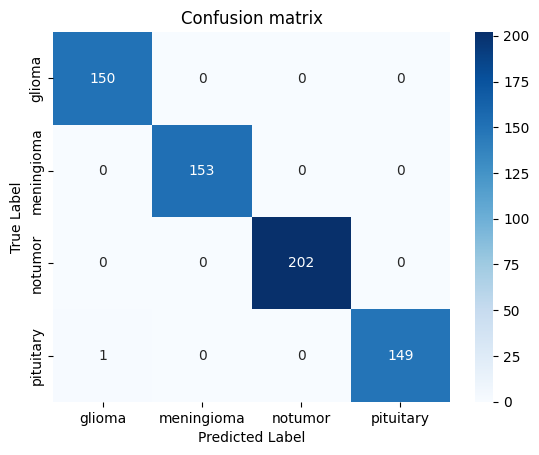

In [17]:
conf_mat = confusion_matrix(true_classes, predicted_classes)

sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues',
            xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title("Confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [82]:
mcc = matthews_corrcoef(true_classes, predicted_classes)
print(f"Matthews Correlation Coeficient {mcc:.4f}")

Matthews Correlation Coeficient 0.9980


In [29]:
classes = list(train_generator.class_indices.keys())

AUC SCORES
Class          AUC Score
glioma         0.99996
meningioma     1.00000
notumor        1.00000
pituitary      0.99997


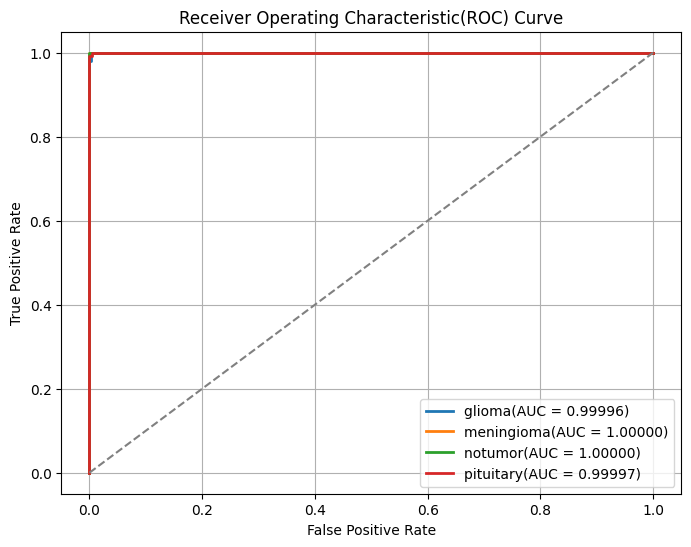

In [67]:
true_classes_bin = label_binarize(true_classes, classes=np.arange(4))

print("AUC SCORES")
print("Class          AUC Score")

plt.figure(figsize=(8, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(true_classes_bin[:, i], predictions[:, i])
    auc_score = auc(fpr, tpr)
    print(f"{classes[i].ljust(15, ' ')}{auc_score:.5f}")
    plt.plot(fpr, tpr, lw=2, label=f"{classes[i]}(AUC = {auc_score:.5f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic(ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Testing with External Data

In [5]:
ext_df_tr = load_data("External Dataset/Train")
ext_df_ts = load_data("External Dataset/Train")
ext_df = pd.concat([ext_df_tr, ext_df_ts])

In [ ]:
ext_test_data = {}

In [21]:
train_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [22]:
def run_test(model, df):
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    class_indices = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

    gen = ImageDataGenerator(rescale=1./255)
    ext_gen = gen.flow_from_dataframe(
        dataframe=df,
        x_col='Image',
        y_col='Class',
        target_size=(299, 299),
        batch_size=16,
        class_mode='categorical',
        shuffle=False, verbose=0
    )

    t_c = ext_gen.classes
    pred = model.predict(ext_gen, verbose=0)
    p_c = np.argmax(pred, axis=1)

    print(classification_report(t_c, p_c, digits=4))

    mcc = matthews_corrcoef(t_c, p_c)
    print(f"Matthews Correlation Coefficient {mcc:.4f}")

    with open('Logs/external_testing_cr.json', 'w') as f:
        json.dump(classification_report(t_c, p_c, output_dict=True), f)

    conf_mat = confusion_matrix(t_c, p_c)
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues',
                xticklabels=class_indices, yticklabels=class_indices)
    plt.title("Confusion matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    t_c_bin = label_binarize(t_c, classes=np.arange(4))

    print("\nAUC SCORES")
    AUC = {}
    print("Class          AUC Score")

    plt.figure(figsize=(8, 6))
    for i in range(4):
        fpr, tpr, _ = roc_curve(t_c_bin[:, i], pred[:, i])
        auc_score = auc(fpr, tpr)
        AUC[classes[i]] = auc_score
        print(f"{classes[i].ljust(15, ' ')}{auc_score:.5f}")
        plt.plot(fpr, tpr, lw=2, label=f"{classes[i]}(AUC = {auc_score:.5f})")

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic(ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return classification_report(t_c, p_c, output_dict=True), mcc, AUC

### epoch 11 Model

Found 49704 validated image filenames belonging to 4 classes.
              precision    recall  f1-score   support

           0     0.9955    0.9710    0.9831     13990
           1     0.9970    0.9552    0.9756     11870
           2     0.9325    0.9992    0.9647     11786
           3     0.9930    0.9930    0.9930     12058

    accuracy                         0.9792     49704
   macro avg     0.9795    0.9796    0.9791     49704
weighted avg     0.9803    0.9792    0.9794     49704

Matthews Correlation Coefficient 0.9726

AUC SCORES
Class          AUC Score
glioma         0.99946
meningioma     0.99968
notumor        0.99986
pituitary      0.99986


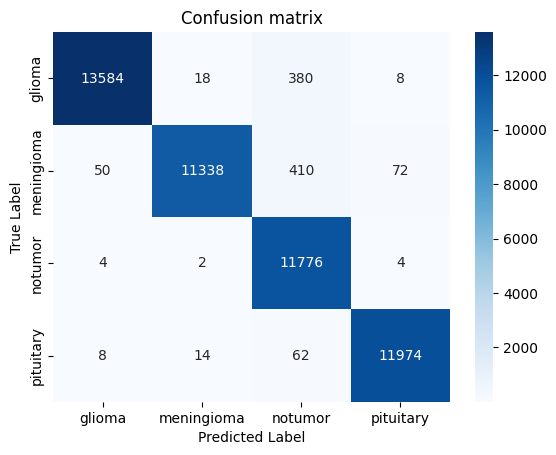

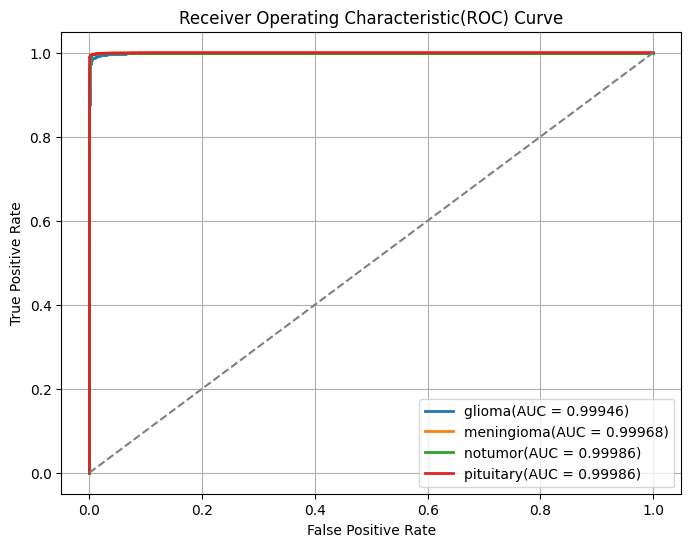

In [103]:
model = load_model(f'Models/Xception/model_epoch_11.keras')
cr, mcc, auc = run_test(model, ext_df)
ext_test_data['11'] = {
    'CR': cr, 'MCC': mcc, 'AUC': auc
}

### epoch 13 Model

Found 49704 validated image filenames belonging to 4 classes.
              precision    recall  f1-score   support

           0     0.9963    0.9959    0.9961     13990
           1     0.9916    0.9956    0.9936     11870
           2     0.9926    0.9983    0.9954     11786
           3     0.9992    0.9900    0.9946     12058

    accuracy                         0.9950     49704
   macro avg     0.9949    0.9950    0.9949     49704
weighted avg     0.9950    0.9950    0.9950     49704

Matthews Correlation Coefficient 0.9933

AUC SCORES
Class          AUC Score
glioma         0.99992
meningioma     0.99992
notumor        0.99999
pituitary      0.99998


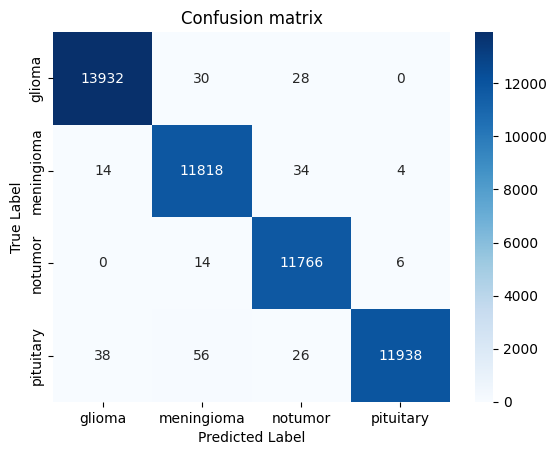

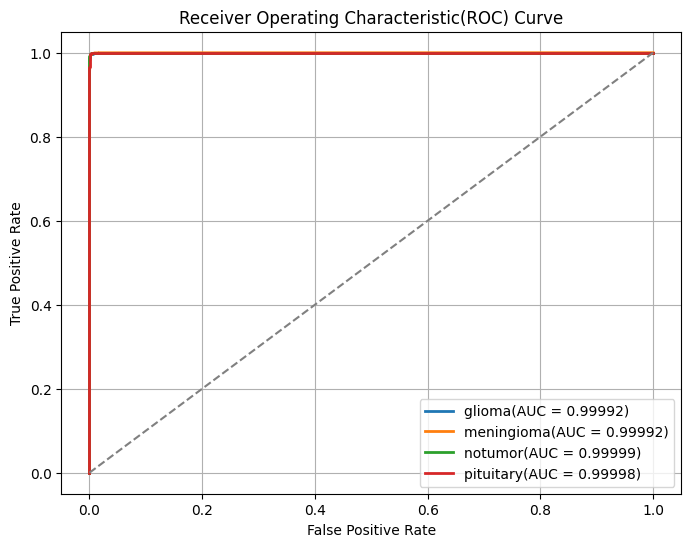

In [106]:
model = load_model(f'Models/Xception/model_epoch_13.keras')
cr, mcc, auc_score = run_test(model, ext_df)
ext_test_data['13'] = {
    'CR': cr, 'MCC': mcc, 'AUC': auc_score
}

### epoch 16 Model

Found 49704 validated image filenames belonging to 4 classes.
              precision    recall  f1-score   support

           0     0.9949    0.9760    0.9854     13990
           1     0.9969    0.9887    0.9928     11870
           2     0.9576    1.0000    0.9783     11786
           3     0.9993    0.9862    0.9927     12058

    accuracy                         0.9872     49704
   macro avg     0.9872    0.9877    0.9873     49704
weighted avg     0.9876    0.9872    0.9873     49704

Matthews Correlation Coefficient 0.9830

AUC SCORES
Class          AUC Score
glioma         0.99846
meningioma     0.99988
notumor        0.99988
pituitary      0.99992


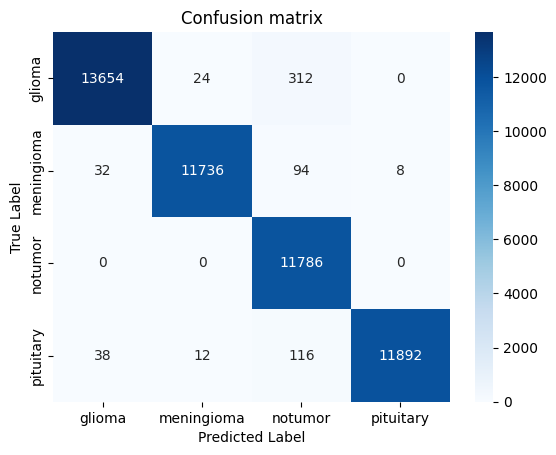

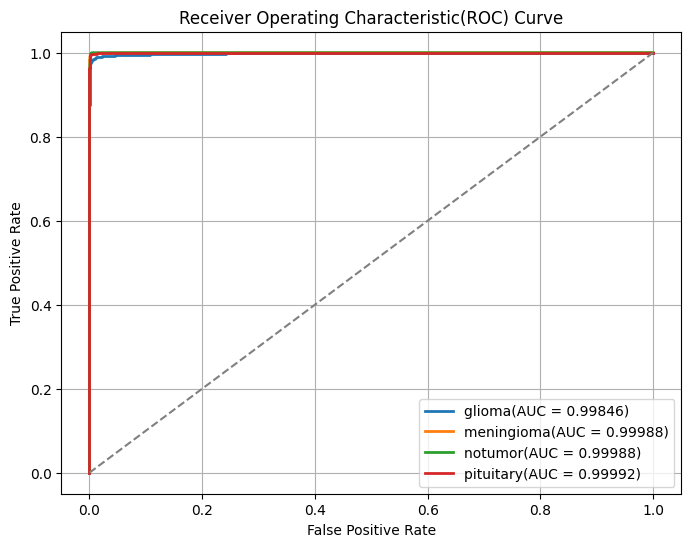

In [23]:
model = load_model(f'Models/Xception/model_epoch_16.keras')
cr, mcc, auc_score = run_test(model, ext_df)
ext_test_data['16'] = {
    'CR': cr, 'MCC': mcc, 'AUC': auc_score
}

In [25]:
import json 
with open(r'Logs\External_testing.json', 'w') as f:
    json.dump(ext_test_data, f)